In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def load(f):
    F = open(f,"r")
    out = []
    label = []
    for l in F:
        temp = [int(t) for t in l.split(",")]
        out.append(temp[1:])
        label.append(temp[0])
        
    return np.array(out),np.array(label)

train_data,train_label = load("./mnist_train.csv")
test_data,test_label = load("./mnist_test.csv")

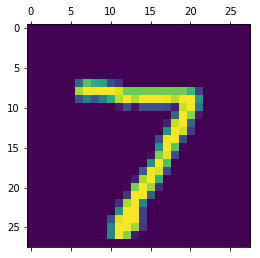

In [4]:
plt.matshow(np.reshape(test_data[0],[28,28]))
plt.show()

In [5]:
batch_size = 16
data_size = len(test_data[0])
data_edge = int(np.sqrt(data_size))
learning_rate = .001
n_epochs = 2000
n_labels = 10

rec_state_size = 32

In [6]:
m = np.mean(train_data)
s = np.std(train_data)

normed_data = (train_data - m)/s

In [7]:
tf.reset_default_graph()

inputs = tf.placeholder(tf.float32,shape = (batch_size, data_size))
series = tf.transpose(tf.reshape(inputs,(-1,data_edge,data_edge)),[0,2,1])

labels = tf.placeholder(tf.float32,shape = (batch_size,10))

init_state = tf.zeros(shape = [rec_state_size])

This next cell is the powerhouse. The function I define takes a single time step batch of inputs, and the current state of the network, and returns an updated state using a single hidden layer of nonlinearity.

Note the `name` keyword and `reuse = tf.AUTO_REUSE`. The name identifies this layer unambiguously, and `tf.AUTO_REUSE` tells tensorflow to reuse the weights if this layer already exists, and create them if it doesn't. That way, every time we call the function `get_next_state`, it applies the same parameters to the inputs, and the gradients are tied across all time steps.

Next I have constructed a loop which recursively feeds the RNN state and a single "time" slice to `get_next_state`, and records the results in a list `state_out`. Afterwards we concatenate (`tf.concat`) them all together along the 1-th axis, generating a time series of state variables. 

Lastly, we reshape the time-dependent state and pass them all through a single dense layer to translate them into logits in the label dimention (`probs`).

In [8]:
def get_next_state(INP,STATE):
    net = tf.layers.dense(tf.concat([INP,STATE],axis = -1),128,name = "rnn_l1",reuse = tf.AUTO_REUSE,activation = tf.nn.relu)
    net = tf.layers.dense(net,STATE.shape[-1],name = "rnn_l2",reuse = tf.AUTO_REUSE)

    return net

state_out = [tf.tile(tf.expand_dims(init_state,0),(batch_size,1))]

for k in range(data_edge):
        state_out.append(get_next_state(series[:,k],state_out[-1]))
        
state_out = tf.stack(state_out,axis = 1)
print(state_out.shape)

flattened_state = tf.reshape(state_out,[-1,rec_state_size])
flattened_probs = tf.layers.dense(flattened_state,n_labels)
probs = tf.reshape(flattened_probs,[state_out.shape[0],state_out.shape[1],n_labels])

print(probs.shape)

(16, 29, 32)
(16, 29, 10)


Here I constrtuct the loss function. I take the mean cross-entropy loss between prediction and label in the final `test_time` time steps. There is some shuffling of dimentions that happens here which could probably be skipped with a clever application of keyowrd arguments in various tensorflow functions. 

In [9]:
test_time = 10

time_label = tf.tile(tf.expand_dims(labels,1),[1,probs.shape[1],1])
flattened_label = tf.reshape(time_label[:,-test_time:],[-1,n_labels])

flattened_probs = tf.reshape(probs[:,-test_time:],[-1,n_labels])
test_probs = tf.nn.softmax(probs,axis = -1)

loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels = flattened_label,logits = flattened_probs))

adam = tf.train.AdamOptimizer()
train = adam.minimize(loss)

In [10]:
def make_1hot(l):
    out = np.zeros(shape = (len(l),n_labels))
    for k in range(len(l)):
        out[k][l[k]] = 1
        
    return out

def MNIST_err(l,p):
    out = []
    for k in range(len(l)):
        if l[k][np.argmax(p[k])] == 1:
            out.append(1)
        else:
            out.append(0)
            
    return np.mean(out)

In [11]:
init = tf.global_variables_initializer()
config = tf.ConfigProto(device_count = {'GPU': 0})
sess = tf.Session(config=config)
sess.run(init)

In [12]:
results = []
print_freq = 100
test_freq = 100
normed_test = (test_data - m)/s
test_label_1h = make_1hot(test_label)

for k in range(n_epochs):
    b_index = np.random.choice(range(len(test_data)),batch_size,replace = False)
    batch_data = normed_data[b_index]
    batch_labels = make_1hot(train_label[b_index])
    
    _,train_loss = sess.run([train,loss],{inputs:batch_data,labels:batch_labels})

    if k%test_freq == 0:
        tres = []
        for j in range(len(normed_test)//16):
            tres.append(sess.run(loss,{inputs:normed_test[j*16:(j+1)*16],labels:test_label_1h[j*16:(j+1)*16]}))
                        
        tres = np.mean(tres)
        results.append([k,train_loss,tres])
                        
    if k%print_freq == 0:
        print("{}\t{}\t{}".format(k,train_loss,tres))
        
        
results = np.array(results)

0	2.4958183765411377	2.423921585083008
100	1.5099488496780396	1.5745511054992676
200	1.0956541299819946	1.0987980365753174
300	0.8476332426071167	0.814119815826416
400	0.5233297348022461	0.7473461031913757
500	0.881984531879425	0.9132543802261353
600	0.8253121376037598	0.7673379182815552
700	1.3356043100357056	0.6909636855125427
800	0.4544600546360016	0.6316205859184265
900	1.1071882247924805	0.7389110326766968
1000	0.31282252073287964	0.5574753880500793
1100	0.5840891003608704	0.5345768332481384
1200	0.15448890626430511	0.6112287044525146
1300	0.3355256915092468	0.45118075609207153
1400	0.4396427571773529	0.48295941948890686
1500	0.1134546771645546	0.4758089780807495
1600	0.8984893560409546	0.42554160952568054
1700	0.4067865014076233	0.4064638316631317
1800	1.0619910955429077	0.4593603014945984
1900	0.14062285423278809	0.47160014510154724


In [13]:
test = sess.run(test_probs,{inputs:normed_test[:16],labels:test_label_1h[:16]})
sess.close()

Now it's always a clever idea to visualize the test performance to make sure your algorithm isn't just learning garbage! 

Here I will visualize the probabilities at each time step, against the image of the digit (aligned so that you can see what part of the image it was looking at at each time).

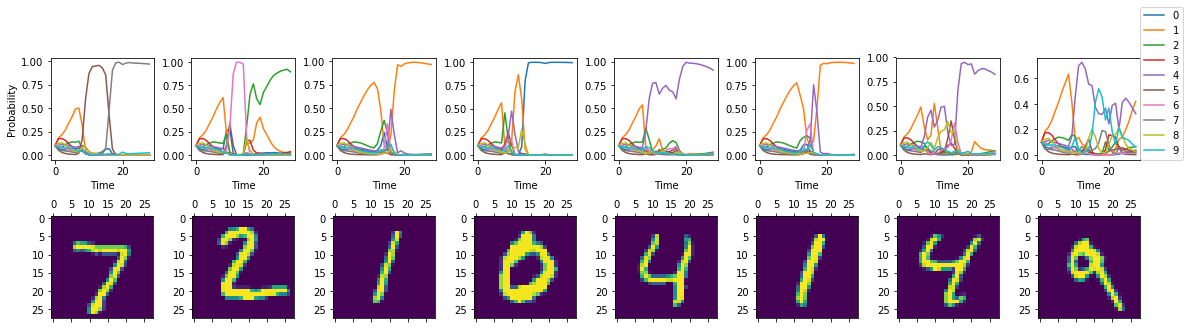

In [15]:
nfig = 8
fig,sub = plt.subplots(2,nfig,figsize = (nfig*2,4))

for ii in range(nfig):
    for kk in range(10):
        sub[0,ii].plot(test[ii,:,kk],label = kk)
        sub[0,ii].set_xlabel('Time')
    sub[1,ii].matshow(np.reshape(test_data[ii],[data_edge,data_edge]))

sub[0,0].set_ylabel('Probability')
sub[0,-1].legend(loc = [1,0])
plt.tight_layout()
plt.show()